# Multiple 2D Gaussian fitting
This little handbook can be used to fit multiple 2D Gaussian functions to an image. The idea can be applied to solve other multi fitting problems.

It has become very common to do so nowadays when either the position or the intensity of atomic columns is needed from STEM images. 

All the Gaussian functions are fitted at the same time, which might take a while if too many Gaussians and parameters are given. But fitting can be quicker if not always using the default fitting parameters for least_sqares.


## Author

* 2021-05-05, Yisong Han (yisong.han@gmail.com)

## Changes


In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image
import scipy.optimize as opt

## Read a *.tif image

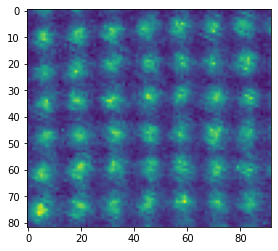

In [22]:
im = Image.open('MgO.tif')
imagedata = np.array(im)

height = im.height
width = im.width
plt.imshow(imagedata)
plt.show()

## Define a 2D Gaussian function
Normally all Gaussian functions have the same sigma.

The image may still have a background - offset.

In [23]:
def twoD_Gaussian(xy, amplitude, xo, yo, sigma, offset):
    theta = 0
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma**2) + (np.sin(theta)**2)/(2*sigma**2)
    b = -(np.sin(2*theta))/(4*sigma**2) + (np.sin(2*theta))/(4*sigma**2)
    c = (np.sin(theta)**2)/(2*sigma**2) + (np.cos(theta)**2)/(2*sigma**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel() + offset

## Create a mesh the size of image

In [24]:
# create x, y coordinates
x = np.arange(0, height).astype('float')
y = np.arange(0, width).astype('float')
y, x = np.meshgrid(y, x)
xy = (x, y)

## load/prepare guessed parameters
I got the guessed parameters using ImageJ.

It is a bit clumsy to convert the data into a 1D list.

In [14]:
particle_pos = pd.read_csv('MgO.csv', 
                           names=['a', 'b', 'max', 'x', 'y'])

particle_pos.reset_index(inplace=True)
particle_pos = particle_pos.astype('float')

# a dict to hold all the parameters
params_dict = {}
for idx in range(len(particle_pos.index)):
    params_dict[idx] = [particle_pos.loc[idx, 'max'],
                   particle_pos.loc[idx, 'y'],
                   particle_pos.loc[idx, 'x']]

# convert dict in to one single list for fitting
params_lst = []
for key in range(len(params_dict)):
    params_lst += params_dict[key]
    
# finally add up guessed sigma and offset, which should be the same for all Gaussians
params_lst += [2.9, 10000.]  

## Create a super function by adding up all individual 2D Gaussians

In [15]:
def func_all(xy, *params):
    x, y = xy
    z = np.zeros_like(x).ravel()
    
    for i in range(0, len(params) - 2, 3):
        amp = params[i]
        xo = params[i + 1]
        yo = params[i + 2]
        sigma = params[-2]
        offset = params[-1]
        z += twoD_Gaussian(xy, amp, xo, yo, sigma, offset)
    return z

## Fit image

In [16]:
popt, pcov = opt.curve_fit(func_all, xy, imagedata.ravel(), p0=params_lst, maxfev = 1000000)

## reconstruct an image based on fitting

In [17]:
fitted = func_all(xy, *popt).reshape(height, width)

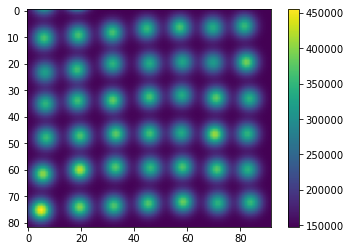

In [18]:
plt.imshow(fitted)
plt.colorbar()
plt.show()

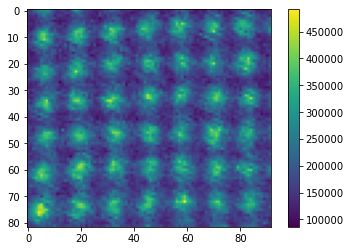

In [19]:
plt.imshow(imagedata)
plt.colorbar()
plt.show()

## check fitting quality

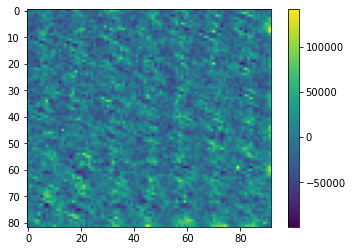

In [20]:
plt.imshow(imagedata - fitted)
plt.colorbar()
plt.show()